In [242]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

In [243]:
data = pd.read_csv('raw_data/ActR08TATB.csv', delimiter=';')
data.head(5)

,TA,TB
0,9.67,6.45
1,9.62,9.64
2,9.50,8.53
3,10.88,9.20
4,8.94,4.55


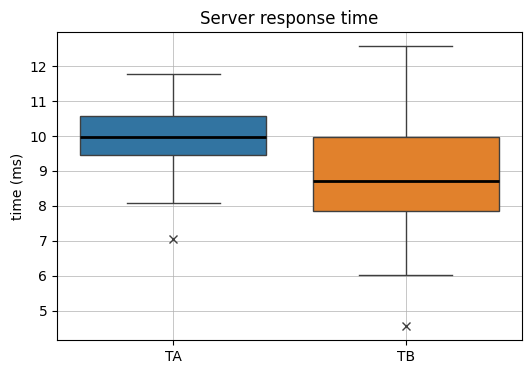

In [244]:
plt.figure(figsize=(6, 4))
ax = sns.boxplot(data=data,
                 flierprops={"marker": "x"},
                 medianprops={"color": "black", "linewidth": 2})
plt.grid(lw=0.5)
plt.title('Server response time')
plt.ylabel('time (ms)')
plt.show()


In [245]:
mean_ta = data.TA.mean()
mean_tb = data.TB.mean()
mean_ta - mean_tb

1.0322000000000013

In [246]:
mean_ta

9.935

In [247]:
mean_tb

8.9028

In [248]:
variance_ta = data.TA.var()
variance_ta

0.8103397959183676

In [249]:
variance_tb = data.TB.var()
variance_tb

3.052906285714285

In [250]:
z = (mean_ta - mean_tb) / (math.sqrt((variance_ta/len(data.TA) + variance_tb/len(data.TB))))
z

3.7134080154690747

In [251]:
from scipy.stats import norm
1-norm.cdf(z)

0.0001022434048687515

b

In [252]:
from scipy import stats
z = norm.ppf(.005)
z

-2.575829303548901

In [253]:
m = z * math.sqrt((variance_ta/len(data.TA))+(variance_tb/len(data.TB)))
m

-0.715992154928153

In [254]:
(mean_ta-mean_tb) + m

0.3162078450718483

In [255]:
(mean_ta-mean_tb) - m

1.7481921549281543

C

In [256]:
tolerated_time = lambda x: 1 if x < 9 else 0

data['TA_tolerated'] = data['TA'].apply(tolerated_time)
data['TB_tolerated'] = data['TB'].apply(tolerated_time)

In [257]:
data.head(5)

,TA,TB,TA_tolerated,TB_tolerated
0,9.67,6.45,0,1
1,9.62,9.64,0,0
2,9.50,8.53,0,1
3,10.88,9.20,0,0
4,8.94,4.55,1,1


In [258]:
len(data[data['TA_tolerated'] == 1])

6

In [259]:
pa = len(data[data['TA_tolerated'] == 1]) / len(data.TA_tolerated)
pa

0.12

In [260]:
len(data[data['TB_tolerated'] == 1])

31

In [261]:
pb = len(data[data['TB_tolerated'] == 1]) / len(data.TB_tolerated)
pb

0.62

In [262]:
p_pool = (len(data.TA_tolerated) * pa + len(data.TB_tolerated) * pb) / (len(data.TA_tolerated) + len(data.TB_tolerated))
p_pool

0.37

In [263]:
z = (pa - pb) / (math.sqrt(p_pool * (1-p_pool) * (1/len(data.TA_tolerated) + 1/len(data.TB_tolerated))))
z

-5.178081383343334

In [264]:
2*norm.cdf(z)

2.2417943998316116e-07

reject null hypothesis

bootstraped proportion

In [265]:
# permutation test
import random

def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = list(random.sample(range(n), nB))
    idx_A = list(set(range(n)) - set(idx_B))
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

Observed difference: -50.0%


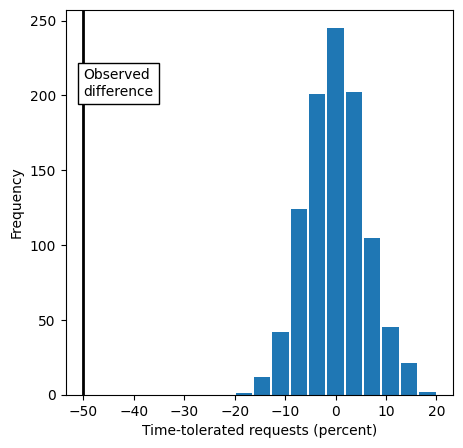

In [266]:
obs_pct_diff = (pa - pb) * 100
print(f'Observed difference: {obs_pct_diff}%')

tolerated = [0] * (len(data[data['TA_tolerated'] == 0]) + len(data[data['TA_tolerated'] == 0]))
tolerated.extend([1] * (len(data[data['TA_tolerated'] == 1]) + len(data[data['TA_tolerated'] == 1])))
tolerated = pd.Series(tolerated)

perm_diffs = [100 * perm_fun(tolerated, int(len(data.TA_tolerated)), int(len(data.TB_tolerated)))
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(obs_pct_diff, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Time-tolerated requests (percent)')
ax.set_ylabel('Frequency')
plt.show()

In [281]:
# frequency with which the chance model produces a result more extreme than the observed result
# P VALUE
np.mean([diff >= abs(obs_pct_diff) for diff in perm_diffs])

0.0

old

In [268]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TA            50 non-null     float64
 1   TB            50 non-null     float64
 2   TA_tolerated  50 non-null     int64  
 3   TB_tolerated  50 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 1.7 KB


In [269]:
data.describe()

,TA,TB,TA_tolerated,TB_tolerated
count,50.000000,50.000000,50.000000,50.000000
mean,9.935000,8.902800,0.120000,0.620000
std,0.900189,1.747257,0.328261,0.490314
min,7.050000,4.550000,0.000000,0.000000
25%,9.445000,7.857500,0.000000,0.000000
50%,9.970000,8.710000,0.000000,1.000000
75%,10.580000,9.970000,0.000000,1.000000
max,11.790000,12.570000,1.000000,1.000000


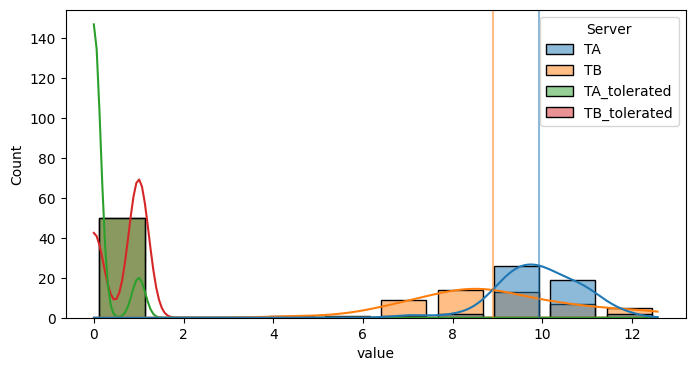

In [270]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(data=data.melt(), x='value', hue='variable', bins=10, kde=True,
             alpha=0.5, shrink=0.8, multiple='layer', ax=ax)

plt.axvline(data.TA.mean(), color='tab:blue', alpha=0.5)
plt.axvline(data.TB.mean(), color='tab:orange', alpha=0.5)

ax.legend_.set_title('Server')
plt.show()